In [ ]:
# Employee Retention

Employee turn-over is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months. It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science.
The data set contains info about the employees and I have to predict when employees are going to quit by understanding the main drivers of employee churn.

In [61]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from collections import defaultdict
from sklearn.model_selection import train_test_split
import lifelines
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn import preprocessing

In [3]:
%matplotlib inline

In [4]:
# read the csv file and have a look at the top few rows
df = pd.read_csv("../Employee_Retention/employee_retention_data.csv")
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [39]:
# know the datatype of each column and make conversions when necessary
columns = list(df.columns)
for x in columns:
    print 'The type of %s is' % x, type(df[x][0])

The type of employee_id is <type 'numpy.float64'>
The type of company_id is <type 'numpy.int64'>
The type of dept is <type 'str'>
The type of seniority is <type 'numpy.int64'>
The type of salary is <type 'numpy.float64'>
The type of join_date is <type 'str'>
The type of quit_date is <type 'str'>


In [5]:
# Add label with quit as 1 and 0 as stay and calculate working length
df['quit_today'] = df['quit_date'].apply(lambda x: 0 if pd.isnull(x) else 1) # assign 0 to employee who doesn't quit 1 to quit
df['quit_date'] = df['quit_date'].apply(lambda x: pd.to_datetime('2015-12-13') if pd.isnull(x) else x) # assign the last day to NaN
df['working_len'] = df['quit_date'].apply(lambda x: pd.to_datetime(x)) - df['join_date'].apply(lambda x: pd.to_datetime(x))
df['working_len'] = df['working_len'].apply(lambda x: x.days)
df['quit_date'] = df['quit_date'].apply(lambda x: None if x == pd.to_datetime('2015-12-13') else x)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_today,working_len
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,426
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040


In [86]:
df = df[df['seniority'] != 98]
df = df[df['seniority'] != 99]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_today,working_len,categories
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,426,medium_low
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389,medium_low
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,medium_high
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,1,578,medium
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,0,783,medium_low


In [88]:
# run kmf survival analysis by department
df_dept_cs = df.loc[df['dept'] == 'customer_service']
df_dept_mkt = df.loc[df['dept'] == 'marketing']
df_dept_ds = df.loc[df['dept'] == 'data_science']
df_dept_des = df.loc[df['dept'] == 'design']
df_dept_eng = df.loc[df['dept'] == 'engineer']
print len(df_dept_cs), len(df_dept_mkt), len(df_dept_ds), len(df_dept_des), len(df_dept_eng)

9179 3165 3190 1380 4612


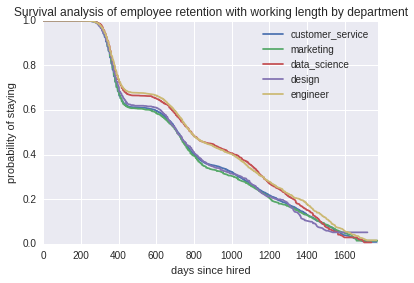

In [89]:
# plot the survival plot by department
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(df_dept_cs['working_len'], event_observed=df_dept_cs['quit_today'], label='customer_service')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_dept_mkt['working_len'], event_observed=df_dept_mkt['quit_today'], label='marketing')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_dept_ds['working_len'], event_observed=df_dept_ds['quit_today'], label='data_science')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_dept_des['working_len'], event_observed=df_dept_des['quit_today'], label='design')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_dept_eng['working_len'], event_observed=df_dept_eng['quit_today'], label='engineer')
kmf.survival_function_.plot(ax=ax)
plt.xlabel('days since hired')
plt.ylabel('probability of staying')
plt.title('Survival analysis of employee retention with working length by department')

In [87]:
# know the range of seniority and salary
print sorted(df['seniority'].unique()), sorted(df['salary'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] [17000.0, 18000.0, 19000.0, 20000.0, 21000.0, 22000.0, 23000.0, 24000.0, 25000.0, 26000.0, 27000.0, 28000.0, 29000.0, 30000.0, 31000.0, 32000.0, 33000.0, 34000.0, 35000.0, 36000.0, 37000.0, 38000.0, 39000.0, 40000.0, 41000.0, 42000.0, 43000.0, 44000.0, 45000.0, 46000.0, 47000.0, 48000.0, 49000.0, 50000.0, 51000.0, 52000.0, 53000.0, 54000.0, 55000.0, 56000.0, 57000.0, 58000.0, 59000.0, 60000.0, 61000.0, 62000.0, 63000.0, 64000.0, 65000.0, 66000.0, 67000.0, 68000.0, 69000.0, 70000.0, 71000.0, 72000.0, 73000.0, 74000.0, 75000.0, 76000.0, 77000.0, 78000.0, 79000.0, 80000.0, 81000.0, 82000.0, 83000.0, 84000.0, 85000.0, 86000.0, 87000.0, 88000.0, 89000.0, 90000.0, 91000.0, 92000.0, 93000.0, 94000.0, 95000.0, 96000.0, 97000.0, 98000.0, 99000.0, 100000.0, 101000.0, 102000.0, 103000.0, 104000.0, 105000.0, 106000.0, 107000.0, 108000.0, 109000.0, 110000.0, 111000.0, 112000.0, 113000.0, 1140

In [90]:
# bin the seniority into 5 categories by their value
bins = [0,5,10,15,20,100]
group_names = ['short', 'medium', 'long', 'longer','longest']
df['categories'] = pd.cut(df['seniority'], bins, labels=group_names)
df_year_to5 = df.loc[df['categories'] == 'short']
df_year_6to10 = df.loc[df['categories'] == 'medium']
df_year_11to15 = df.loc[df['categories'] == 'long']
df_year_16to20 = df.loc[df['categories'] == 'longer']
df_year_above20 = df.loc[df['categories'] == 'longest']

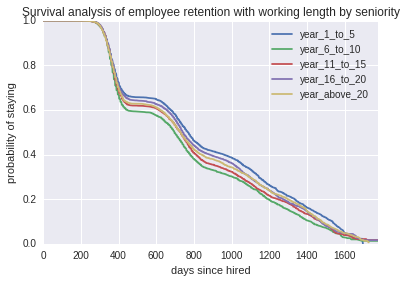

In [91]:
# do the kmf analysis and plot
ax = plt.subplot(111)
kmf.fit(df_year_to5['working_len'], event_observed=df_year_to5['quit_today'], label='year_1_to_5')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_year_6to10['working_len'], event_observed=df_year_6to10['quit_today'], label='year_6_to_10')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_year_11to15['working_len'], event_observed=df_year_11to15['quit_today'], label='year_11_to_15')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_year_16to20['working_len'], event_observed=df_year_16to20['quit_today'], label='year_16_to_20')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_year_above20['working_len'], event_observed=df_year_above20['quit_today'], label='year_above_20')
kmf.survival_function_.plot(ax=ax)
plt.xlabel('days since hired')
plt.ylabel('probability of staying')
plt.title('Survival analysis of employee retention with working length by seniority')

In [92]:
# bin the salary to categories by their values
bins = [50000,100000,150000,200000,300000,410000]
group_names = ['low', 'medium_low', 'medium', 'medium_high','high']
df['categories'] = pd.cut(df['salary'], bins, labels=group_names)
df_sal_low = df.loc[df['categories'] == 'low']
df_sal_med_low = df.loc[df['categories'] == 'medium_low']
df_sal_med = df.loc[df['categories'] == 'medium']
df_sal_med_high = df.loc[df['categories'] == 'medium_high']
df_sal_high = df.loc[df['categories'] == 'high']

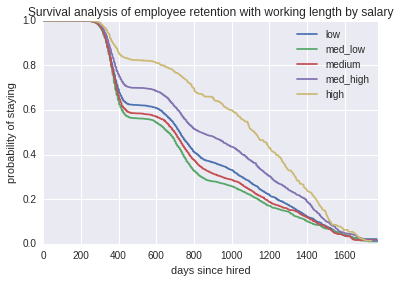

In [93]:
# do the kmf anaysis for the data by salary, which is a strong indicator of their retention, the higher salary, the less likely they quit
ax = plt.subplot(111)
kmf.fit(df_sal_low['working_len'], event_observed=df_sal_low['quit_today'], label='low')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_sal_med_low['working_len'], event_observed=df_sal_med_low['quit_today'], label='med_low')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_sal_med['working_len'], event_observed=df_sal_med['quit_today'], label='medium')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_sal_med_high['working_len'], event_observed=df_sal_med_high['quit_today'], label='med_high')
kmf.survival_function_.plot(ax=ax)
kmf.fit(df_sal_high['working_len'], event_observed=df_sal_high['quit_today'], label='high')
kmf.survival_function_.plot(ax=ax)
plt.xlabel('days since hired')
plt.ylabel('probability of staying')
plt.title('Survival analysis of employee retention with working length by salary')

In [94]:
# do the Cox survival analysis by considering seniority, salary together
cf = CoxPHFitter()
feats = ['seniority','salary','working_len','quit_today']
X = df[feats]
cf.fit(X, 'working_len', event_col='quit_today')
print cf.print_summary()  # access the results using cf.summary
# use cross validation to get the scores of prediction
scores = k_fold_cross_validation(cf, X, 'working_len', event_col='quit_today', k=5)
print scores,np.mean(scores), np.std(scores)

n=24698, number of events=13506

                coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
seniority  7.529e-02  1.078e+00 1.046e-02  7.201e+00 5.973e-13   5.480e-02   9.579e-02  ***
salary    -1.251e-01  8.824e-01 1.035e-02 -1.208e+01 1.272e-33  -1.454e-01  -1.048e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.529
None
[0.52497774279427112, 0.52733282372564549, 0.53844006331125893, 0.52325085275150207, 0.53268374162062393] 0.529337044841 0.00555207124178


In [59]:
cf.predict_cumulative_hazard(X_test).head()

,5339,12313,21318,8048,1457,14028,9403,17595,13236,23707,...,18453,10398,14657,12284,1413,1130,17475,5875,13991,22283
event_at,,,,,,,,,,,,,,,,,,,,,
0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
10.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


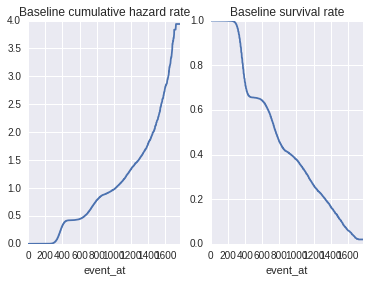

In [95]:
# plot the Cox survival anaysis 
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True)
cf.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False,title='Baseline cumulative hazard rate')
cf.baseline_survival_.plot(ax=axes[0,1], legend=False,title='Baseline survival rate')

In [132]:
df_dept = df.groupby('dept').agg({'quit_today': lambda x: x.sum()/float(len(x)), 'working_len': lambda x: x.sum()/len(x), 'salary': lambda x: x.sum()/len(x)})
df_dept = pd.DataFrame(df_dept.to_records())
df_dept.head()

,dept,salary,quit_today,working_len
0,customer_service,82245.424837,0.554902,561
1,data_science,206885.893417,0.527273,606
2,design,137460.869565,0.563768,573
3,engineer,205544.548016,0.512031,602
4,marketing,135598.042311,0.562993,559


In [103]:
day = pd.to_datetime('2014-01-24')
print day, type(day)

2014-01-24 00:00:00 <class 'pandas.tslib.Timestamp'>


In [104]:
df['hired'] = df['join_date'].apply(lambda x: 1 if pd.to_datetime(x) <= day else 0)
df['quit'] = df['quit_date'].apply(lambda x: 1 if pd.to_datetime(x) <= day else 0)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_today,working_len,hired,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585,0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340,1,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,426,0,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389,1,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040,1,0


In [120]:
df_company = df.groupby('company_id').agg({'hired': sum, 'quit': sum, 'salary': lambda x: x.sum()/len(x)})
df_company['head_count'] = df_company['hired'] - df_company['quit']
print len(df_company),i, day
df_company = pd.DataFrame(df_company.to_records())
df_company.head()

12 60 2014-01-24 00:00:00


,company_id,salary,quit,hired,head_count
0,1,152167.570115,1793,5275,3482
1,2,155728.090952,849,2565,1716
2,3,122118.588578,601,1686,1085
3,4,122721.144520,468,1258,790
4,5,123348.717949,390,1055,665


In [128]:
start_day = pd.to_datetime('2011-01-24')
end_day = pd.to_datetime('2015-12-13')
days = [start_day + timedelta(days=x) for x in range((end_day-start_day).days + 1)]
print len(days), days[:5]

1785 [Timestamp('2011-01-24 00:00:00'), Timestamp('2011-01-25 00:00:00'), Timestamp('2011-01-26 00:00:00'), Timestamp('2011-01-27 00:00:00'), Timestamp('2011-01-28 00:00:00')]


In [113]:
pd.DataFrame.from_dict(d).head()

,2011-01-24 00:00:00,2011-01-25 00:00:00,2011-01-26 00:00:00,2011-01-27 00:00:00,2011-01-28 00:00:00,2011-01-29 00:00:00,2011-01-30 00:00:00,2011-01-31 00:00:00,2011-02-01 00:00:00,2011-02-02 00:00:00,...,2011-03-15 00:00:00,2011-03-16 00:00:00,2011-03-17 00:00:00,2011-03-18 00:00:00,2011-03-19 00:00:00,2011-03-20 00:00:00,2011-03-21 00:00:00,2011-03-22 00:00:00,2011-03-23 00:00:00,2011-03-24 00:00:00
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25,27,29,29,29,29,29,59,66,67,...,234,236,237,237,237,237,268,270,272,272
2,25,27,29,29,29,29,29,59,66,67,...,234,236,237,237,237,237,268,270,272,272
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,19,19,19,19,19,19,31,33,35,...,138,138,138,138,138,138,151,152,152,152


In [125]:
list(df_company['head_count'])[0]

3482

In [129]:
# this method takes too long time to finish.
d = defaultdict(list)
df_copy = df
for i in range(len(days)):
    day = days[i]
    df_copy['hired'] = df_copy['join_date'].apply(lambda x: 1 if pd.to_datetime(x) <= day else 0)
    df_copy['quit'] = df_copy['quit_date'].apply(lambda x: 1 if pd.to_datetime(x) <= day else 0)
    df_new = df_copy.groupby('company_id').agg({'hired': sum, 'quit': sum})
    df_new['head_count'] = df_new['hired'] - df_new['quit']
    df_new = pd.DataFrame(df_new.to_records())
    for j in range(len(df_new)):
        d[list(df_new['company_id'])[j]].append(list(df_new['head_count'])[j])


KeyboardInterrupt: 

In [67]:
feats = ['seniority','salary','working_len']
X = df[feats]
y = df['quit_today']
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_norm = pd.DataFrame(np_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)
X_norm.head()

,0,1,2
0,0.275510,0.184143,0.328072
1,0.193878,0.424552,0.189966
2,0.132653,0.214834,0.238444
3,0.193878,0.250639,0.217587
4,0.224490,0.662404,0.584555


In [68]:
log = LogisticRegression()
score_log = log.fit(X_train, y_train).score(X_test,y_test)
print score_log, log.coef_

0.62058390579 [[ 0.92117214 -0.69941458  1.27646623]]


In [73]:
rf = RandomForestClassifier()
score_rf = rf.fit(X_train, y_train).score(X_test,y_test)
print score_rf, rf.base_estimator_, rf.feature_importances_

0.728655544652 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best') [ 0.07588015  0.25671521  0.66740464]
